In [35]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import os
from pathlib import Path
import timm

In [59]:


train_dir = Path("/Users/jeesuppark/Downloads/aihub-meat-image/Training")

image_dirs = [
    train_dir / "[image]cow_seg_1",
    train_dir / "[image]cow_seg_2",
    train_dir / "[image]cow_seg_3"
]

filepaths = []

for image_dir in image_dirs:
    grade = int(image_dir.stem[-1])  # Extract the last character of the directory name as the grade
    filepaths.extend([str(image_dir / file) for file in os.listdir(image_dir) if file.endswith('.jpg')])

data = pd.DataFrame(filepaths, columns=['Filepath'])

data['File ID'] = [Path(filepath).stem.split('_')[-1] for filepath in data['Filepath']]
print(data)


                                               Filepath File ID
0     /Users/jeesuppark/Downloads/aihub-meat-image/T...  003479
1     /Users/jeesuppark/Downloads/aihub-meat-image/T...  001252
2     /Users/jeesuppark/Downloads/aihub-meat-image/T...  003445
3     /Users/jeesuppark/Downloads/aihub-meat-image/T...  003323
4     /Users/jeesuppark/Downloads/aihub-meat-image/T...  001534
...                                                 ...     ...
2995  /Users/jeesuppark/Downloads/aihub-meat-image/T...  008184
2996  /Users/jeesuppark/Downloads/aihub-meat-image/T...  012335
2997  /Users/jeesuppark/Downloads/aihub-meat-image/T...  008423
2998  /Users/jeesuppark/Downloads/aihub-meat-image/T...  010287
2999  /Users/jeesuppark/Downloads/aihub-meat-image/T...  004594

[3000 rows x 2 columns]


In [60]:
import json
from pathlib import Path
import pandas as pd

train_dir = Path("/Users/jeesuppark/Downloads/aihub-meat-image/Training")

label_dirs = [
    train_dir / "[label]cow_seg_1",
    train_dir / "[label]cow_seg_2",
    train_dir / "[label]cow_seg_3"
]

points_data = pd.DataFrame(columns=['File ID', 'Points'])

for label_dir in label_dirs:
    # Get all JSON file paths in the label_dir
    json_files = label_dir.glob("*.json")

    for json_file in json_files:
        # Load the JSON file
        with open(json_file, 'r') as f:
            label_json = json.load(f)

        # Extract the points from the label JSON
        points = label_json['label_info']['shapes'][0]['points']
        grade = int(label_json['label_info']['shapes'][0]['grade'])-1

        # Convert the points to a string representation
        points_str = str(points)

        # Extract the last ID from the file name
        file_id = json_file.stem.split('_')[-1]


        # Create a temporary DataFrame with the current data
        temp_df = pd.DataFrame({
            'File ID': [file_id], 
            'Points': [points_str],
            'Grade': [grade]
        })

        # Concatenate the temporary DataFrame with the main points_data DataFrame
        points_data = pd.concat([points_data, temp_df], ignore_index=True)

print(points_data)


     File ID                                             Points  Grade
0     002858  [[1701.3333333333335, 1843.0], [1681.333333333...    0.0
1     004125  [[548.2379862700228, 761.8306636155605], [548....    0.0
2     000166  [[808.1440443213296, 763.8781163434902], [808....    0.0
3     000189  [[612.3112128146452, 720.6407322654462], [527....    0.0
4     000473  [[354.5576707726765, 751.2653975363942], [341....    0.0
...      ...                                                ...    ...
2995  004562  [[797.0637119113572, 910.6925207756232], [805....    2.0
2996  004831  [[373.91812865497076, 679.2982456140351], [371...    2.0
2997  011625  [[765.6292906178488, 951.7620137299771], [767....    2.0
2998  002009  [[738.2717989002357, 953.401413982718], [750.8...    2.0
2999  009645  [[628.0886426592797, 932.8531855955678], [647....    2.0

[3000 rows x 3 columns]


In [83]:
train_data = pd.merge(data, points_data, on='File ID', how='inner')
print(train_data)
train_data.to_csv('train_data.csv')


                                               Filepath File ID  \
0     /Users/jeesuppark/Downloads/aihub-meat-image/T...  003479   
1     /Users/jeesuppark/Downloads/aihub-meat-image/T...  001252   
2     /Users/jeesuppark/Downloads/aihub-meat-image/T...  003445   
3     /Users/jeesuppark/Downloads/aihub-meat-image/T...  003323   
4     /Users/jeesuppark/Downloads/aihub-meat-image/T...  001534   
...                                                 ...     ...   
2995  /Users/jeesuppark/Downloads/aihub-meat-image/T...  008184   
2996  /Users/jeesuppark/Downloads/aihub-meat-image/T...  012335   
2997  /Users/jeesuppark/Downloads/aihub-meat-image/T...  008423   
2998  /Users/jeesuppark/Downloads/aihub-meat-image/T...  010287   
2999  /Users/jeesuppark/Downloads/aihub-meat-image/T...  004594   

                                                 Points  Grade  
0     [[346.1919504643963, 726.5634674922602], [361....    0.0  
1     [[584.8512585812356, 711.4874141876429], [559....    0.0  


In [7]:
import cv2
import numpy as np

# Iterate over the rows of the data DataFrame
for index, row in train_data.iterrows():
    # Load the image
    image_path = row['Filepath']
    image = cv2.imread(image_path)

    # Create a blank mask image of the same size as the original image
    mask = np.zeros_like(image)

    # Get the points from the current row
    points = eval(row['Points'])

    # Convert the points to a NumPy array of integer coordinates
    points = np.array(points, dtype=np.int32)

    # Create a mask for the current points
    cv2.fillPoly(mask, [points], (255, 255, 255))

    # Perform the bitwise AND operation between the image and the mask
    masked_image = cv2.bitwise_and(image, mask)

    cv2.imwrite(image_path, masked_image)

print("Masked images applied to the data successfully.")


Masked images applied to the data successfully.


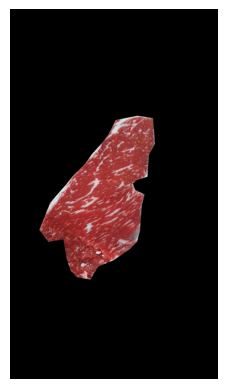

In [8]:
def visualize_image(filepath):
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Visualize a specific image by providing its file path
image_path = train_data['Filepath'][1111]  # Replace 0 with the index of the desired image
visualize_image(image_path)

In [64]:
valid_dir = Path("/Users/jeesuppark/Downloads/aihub-meat-image/Validation")

image_dirs = [
    valid_dir / "[image]cow_seg_1",
    valid_dir / "[image]cow_seg_2",
    valid_dir / "[image]cow_seg_3"
]

filepaths = []

for image_dir in image_dirs:
    grade = int(image_dir.stem[-1])  # Extract the last character of the directory name as the grade
    filepaths.extend([str(image_dir / file) for file in os.listdir(image_dir) if file.endswith('.jpg')])

valid_data = pd.DataFrame(filepaths, columns=['Filepath'])

valid_data['File ID'] = [Path(filepath).stem.split('_')[-1] for filepath in valid_data['Filepath']]
print(valid_data)


                                               Filepath File ID
0     /Users/jeesuppark/Downloads/aihub-meat-image/V...  069878
1     /Users/jeesuppark/Downloads/aihub-meat-image/V...  070440
2     /Users/jeesuppark/Downloads/aihub-meat-image/V...  069887
3     /Users/jeesuppark/Downloads/aihub-meat-image/V...  070871
4     /Users/jeesuppark/Downloads/aihub-meat-image/V...  071206
...                                                 ...     ...
1495  /Users/jeesuppark/Downloads/aihub-meat-image/V...  076499
1496  /Users/jeesuppark/Downloads/aihub-meat-image/V...  072172
1497  /Users/jeesuppark/Downloads/aihub-meat-image/V...  070765
1498  /Users/jeesuppark/Downloads/aihub-meat-image/V...  069552
1499  /Users/jeesuppark/Downloads/aihub-meat-image/V...  077036

[1500 rows x 2 columns]


In [65]:
import json
from pathlib import Path
import pandas as pd

valid_dir = Path("/Users/jeesuppark/Downloads/aihub-meat-image/Validation")

label_dirs = [
    valid_dir / "[label]cow_seg_1",
    valid_dir / "[label]cow_seg_2",
    valid_dir / "[label]cow_seg_3"
]

valid_label = pd.DataFrame(columns=['File ID', 'Points'])

for label_dir in label_dirs:
    # Get all JSON file paths in the label_dir
    json_files = label_dir.glob("*.json")

    for json_file in json_files:
        # Load the JSON file
        with open(json_file, 'r') as f:
            label_json = json.load(f)

        # Extract the points from the label JSON
        points = label_json['label_info']['shapes'][0]['points']
        grade = int(label_json['label_info']['shapes'][0]['grade'])-1

        # Convert the points to a string representation
        points_str = str(points)

        # Extract the last ID from the file name
        file_id = json_file.stem.split('_')[-1]

        # Create a temporary DataFrame with the current data
        temp_df = pd.DataFrame({
            'File ID': [file_id], 
            'Points': [points_str],
            'Grade': [grade]
        })

        # Concatenate the temporary DataFrame with the main points_data DataFrame
        valid_label = pd.concat([valid_label, temp_df], ignore_index=True)

print(valid_label)


     File ID                                             Points  Grade
0     069946  [[557.5383176605486, 702.7858107682314], [478....    0.0
1     070634  [[497.8947368421052, 625.7097288676235], [456....    0.0
2     070458  [[182.10526315789468, 697.7574370709382], [161...    0.0
3     070663  [[655.7894736842104, 1036.4302059496567], [653...    0.0
4     070399  [[384.3213296398892, 708.4764542936286], [376....    0.0
...      ...                                                ...    ...
1495  074158  [[577.3037857802401, 706.6297322253001], [503....    2.0
1496  072825  [[243.00751879699246, 570.0075187969925], [243...    2.0
1497  075460  [[111.28526856121874, 405.7941248002985], [121...    2.0
1498  074230  [[691.8005540166205, 777.7285318559556], [708....    2.0
1499  070336  [[298.2043343653251, 344.0897832817338], [298....    2.0

[1500 rows x 3 columns]


In [84]:
test_data = pd.merge(valid_data, valid_label, on='File ID', how='inner')
print(test_data)
test_data.to_csv('test_data.csv')


                                               Filepath File ID  \
0     /Users/jeesuppark/Downloads/aihub-meat-image/V...  069878   
1     /Users/jeesuppark/Downloads/aihub-meat-image/V...  070440   
2     /Users/jeesuppark/Downloads/aihub-meat-image/V...  069887   
3     /Users/jeesuppark/Downloads/aihub-meat-image/V...  070871   
4     /Users/jeesuppark/Downloads/aihub-meat-image/V...  071206   
...                                                 ...     ...   
1495  /Users/jeesuppark/Downloads/aihub-meat-image/V...  076499   
1496  /Users/jeesuppark/Downloads/aihub-meat-image/V...  072172   
1497  /Users/jeesuppark/Downloads/aihub-meat-image/V...  070765   
1498  /Users/jeesuppark/Downloads/aihub-meat-image/V...  069552   
1499  /Users/jeesuppark/Downloads/aihub-meat-image/V...  077036   

                                                 Points  Grade  
0     [[377.03703703703695, 561.5594541910331], [279...    0.0  
1     [[724.4393592677344, 1043.295194508009], [745....    0.0  


In [12]:
import cv2
import numpy as np

# Iterate over the rows of the data DataFrame
for index, row in test_data.iterrows():
    # Load the image
    image_path = row['Filepath']
    image = cv2.imread(image_path)
    
    # Create a blank mask image of the same size as the original image
    mask = np.zeros_like(image)
    # Get the points from the current row
    points = eval(row['Points'])
    
    # Convert the points to a NumPy array of integer coordinates
    points = np.array(points, dtype=np.int32)
    # Create a mask for the current points
    cv2.fillPoly(mask, [points], (255, 255, 255))
    # Perform the bitwise AND operation between the image and the mask
    masked_image = cv2.bitwise_and(image, mask)

    cv2.imwrite(image_path, masked_image)
    
    

print("Masked images applied to the data successfully.")


Masked images applied to the data successfully.


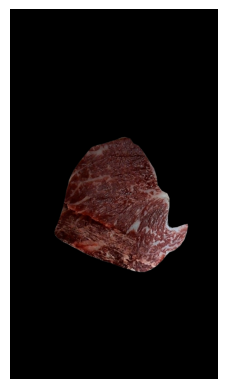

In [13]:
# Visualize a specific image by providing its file path
id = 21 # Replace with the index of the desired image
image_path = test_data['Filepath'][id]  
visualize_image(image_path)

In [14]:
pip install pytorch_pretrained_vit

Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

In [16]:
img = Image.open(train_data['Filepath'][0])

transform = Compose([Resize((224, 224)), ToTensor()])
x = transform(img)
x = x.unsqueeze(0) # add batch dim
x.shape

torch.Size([1, 3, 224, 224])

In [17]:
patch_size = 16 # 16 pixels
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)


In [18]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

        
    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
        self.scaling = (self.emb_size // num_heads) ** -0.5

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        queries = rearrange(self.queries(x), "b n (h d) -> b h n d", h=self.num_heads)
        keys = rearrange(self.keys(x), "b n (h d) -> b h n d", h=self.num_heads)
        values  = rearrange(self.values(x), "b n (h d) -> b h n d", h=self.num_heads)
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
            
        att = F.softmax(energy, dim=-1) * self.scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out
    
patches_embedded = PatchEmbedding()(x)
MultiHeadAttention()(patches_embedded).shape

torch.Size([1, 197, 768])

In [20]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
        
    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [21]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(), # relu or gelu 
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [22]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [23]:
patches_embedded = PatchEmbedding()(x)
TransformerEncoderBlock()(patches_embedded).shape

torch.Size([1, 197, 768])

In [24]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])
                

In [25]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 3):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size), 
            nn.Linear(emb_size, n_classes))

In [26]:
class ViT(nn.Sequential):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 3,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )
        

In [27]:
summary(ViT(), (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
         Rearrange-2             [-1, 196, 768]               0
    PatchEmbedding-3             [-1, 197, 768]               0
         LayerNorm-4             [-1, 197, 768]           1,536
            Linear-5             [-1, 197, 768]         590,592
            Linear-6             [-1, 197, 768]         590,592
            Linear-7             [-1, 197, 768]         590,592
           Dropout-8          [-1, 8, 197, 197]               0
            Linear-9             [-1, 197, 768]         590,592
MultiHeadAttention-10             [-1, 197, 768]               0
          Dropout-11             [-1, 197, 768]               0
      ResidualAdd-12             [-1, 197, 768]               0
        LayerNorm-13             [-1, 197, 768]           1,536
           Linear-14            [-1, 1

In [85]:
class Vit(nn.Module):
    def __init__(self, pretrained = True):
        '''
        This is the constructor for the vision transformer
        '''
        super(Vit, self).__init__()
        # we can change quite a few parameters in the model by defining a model_cfg dictionary
        model_cfg = dict(drop_path_rate = 0.05, drop_rate = 0.1)
        #here it create a 16*16 batch ViT with input image size 224
        self.model = timm.create_model('vit_base_patch16_224', pretrained = pretrained, **dict(model_cfg))
        #This last layer passes the final 1000 output features from ViT MLP head to a linear layer of 6(since
        #we have 6 classes)
        self.model.head = nn.Linear(self.model.head.in_features, 3)
    
    def forward(self, x):
        x = self.model(x)
        #we apply a softmax on the output of 6 to get the class 
        x = F.softmax(x, dim = 1)
        return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


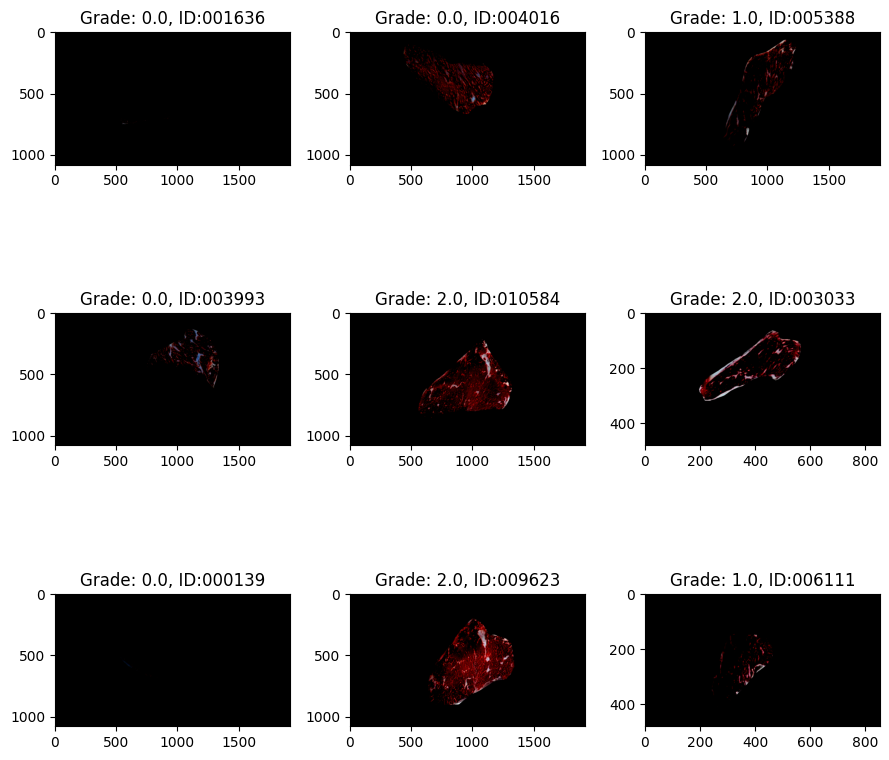

In [68]:
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

# Define the transform to apply to the image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Assuming your dataset is a Pandas DataFrame
dataset = train_data  # Replace 'your_dataframe' with your actual DataFrame

# Generate random indices to select random samples from the dataset
random_indices = random.sample(range(len(dataset)), k=9)  # Change k to the desired number of samples

# Create a subplot to display the images
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

# Iterate over the random indices and display the images
for i, index in enumerate(random_indices):
    row = dataset.iloc[index]
    img_path = row['Filepath']
    grade = row['Grade']
    id = row['File ID']

    image = Image.open(img_path)
    image = image.transpose(Image.TRANSPOSE)  # Transpose the image data to (height, width, channels)
    image = transform(image)

    row_idx = i // 3
    col_idx = i % 3

    axes[row_idx, col_idx].imshow(image.numpy().transpose(1, 2, 0), cmap='gray')  # Transpose the image data to (height, width, channels)
    axes[row_idx, col_idx].set_title(f"Grade: {grade}, ID:{id}")

plt.tight_layout()
plt.show()


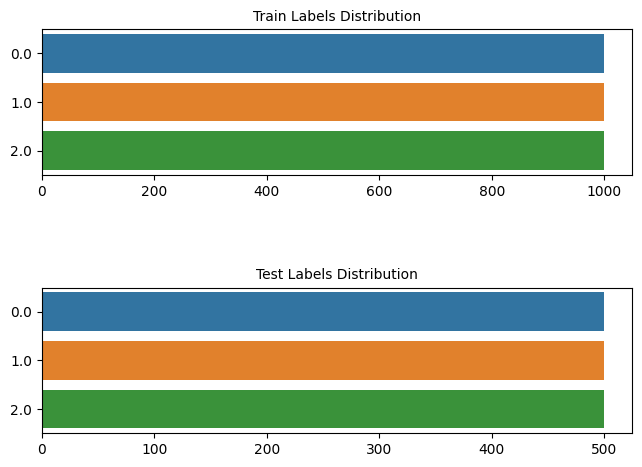

In [69]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=10)
train_distribution = train_data['Grade'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Test Labels Distribution
ax2.set_title('Test Labels Distribution', fontsize=10)
test_distribution = test_data['Grade'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax2);

In [30]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
import matplotlib.ticker as ticker
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn as nn
import timm
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim
from torchvision.io import read_image

#Define hyperparameters
batch_size = 64
lr = 5e-5
epochs = 5

In [71]:
from PIL import Image

class CreateImageDataset(Dataset):
    def __init__(self, data, resize_shape=(224, 224), transform=None):
        super().__init__()
        self.data = data
        self.transform = transform
        self.resize_shape = resize_shape


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data['Filepath'].iloc[idx]
        label = self.data['Grade'].iloc[idx]
        
        image = Image.open(img_path)
        image = image.resize(self.resize_shape, Image.BILINEAR)

        if self.transform:
            image = self.transform(image)

        return image, label



In [72]:
train_data.reset_index(drop=True, inplace=True)  # Reset the index of the train_data DataFrame
valid_data.reset_index(drop=True, inplace=True)  # Reset the index of the train_data DataFrame
train_dataset = CreateImageDataset(train_data, transform=transforms.ToTensor())
valid_dataset = CreateImageDataset(train_data, transform=transforms.ToTensor())

In [73]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)

In [94]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = ViT()

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = ReduceLROnPlateau(optimizer, patience = 3, factor = 0.5, threshold = 0.001)
train_loss, val_loss, train_acc, val_acc =[], [], [], []
best_acc = 0
for epoch in range(epochs):
    #training
    model.train()
    total_loss, total_correct = 0,0
    for x, y in tqdm(train_dataloader):
        output = model(x)
        _, preds = torch.max(output, 1)
        loss = criterion(output, y.long())
        print("Output")
        print(output)
        print("Output shape")
        print(output.shape)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        print("Y")
        print(y)
        print("preds")
        print(preds)
        total_correct += torch.sum(preds == torch.max(y, 1)[1]).item()/len(x)
    train_loss.append(total_loss/len(train_dataloader))
    train_acc.append(total_correct/len(train_dataloader))
    
    #validation
    model.eval()
    total_loss, total_correct = 0,0
    with torch.no_grad():
        for x, y in valid_dataloader:
            x = x.to(device)
            y = y.to(device).float()
            output = model(x)
            _, preds = torch.max(output, 1)
            loss = criterion(output, y)
            optimizer.zero_grad()
            total_loss += loss.item()
            total_correct += torch.sum(preds == torch.max(y, 1)[1]).item()/len(x)
        val_loss.append(total_loss/len(valid_dataloader))
        val_acc.append(total_correct/len(valid_dataloader))   
    scheduler.step(val_loss[-1])
    
    #saving best model
    if val_acc[-1]>best_acc:
        best_acc = val_acc[-1]
        torch.save({
            'epoch':epoch,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
            'loss':val_loss[-1],
            'acc':val_acc[-1]
        }, '/kaggle/working/model_checkpoint.pt')
    print('The Validation Loss is {} and the validation accuracy is {}'.format(val_loss[-1],val_acc[-1]))
    print('The Training Loss is {} and the training accuracy is {}'.format(train_loss[-1],train_acc[-1]))

#plot the curves
plt.plot(train_acc, label = 'train_acc')
plt.plot(val_acc, label = 'val_acc')
plt.plot(train_loss, label = 'train_loss')
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.title('Accuracy and Loss Plots')
plt.show()

cpu


  0%|                                                    | 0/47 [00:00<?, ?it/s]

tensor(1.4171, grad_fn=<NllLossBackward0>)
Output
tensor([[ 1.0373, -0.6652, -0.5994],
        [ 1.0466, -0.6341, -0.5221],
        [ 1.0402, -0.6683, -0.5852],
        [ 1.0809, -0.6581, -0.5726],
        [ 1.0439, -0.6617, -0.5761],
        [ 1.0682, -0.6603, -0.5837],
        [ 1.0438, -0.6617, -0.5858],
        [ 1.0614, -0.6652, -0.5920],
        [ 1.0930, -0.6261, -0.5287],
        [ 1.0552, -0.6537, -0.5891],
        [ 1.0634, -0.6532, -0.5608],
        [ 1.0647, -0.6444, -0.5621],
        [ 1.0659, -0.6527, -0.5539],
        [ 1.0617, -0.6623, -0.5852],
        [ 1.0734, -0.5978, -0.4791],
        [ 1.0634, -0.6535, -0.5532],
        [ 1.0445, -0.6880, -0.6135],
        [ 1.0751, -0.5990, -0.4959],
        [ 1.0652, -0.6298, -0.5411],
        [ 1.0560, -0.6648, -0.5835],
        [ 1.0605, -0.6504, -0.5445],
        [ 1.0514, -0.6420, -0.5772],
        [ 1.0442, -0.6772, -0.6001],
        [ 1.0512, -0.6711, -0.5939],
        [ 1.0705, -0.6368, -0.5671],
        [ 1.0492, -0.6732

  0%|                                                    | 0/47 [00:17<?, ?it/s]

Y
tensor([0., 2., 2., 1., 1., 0., 2., 0., 2., 2., 0., 0., 2., 0., 0., 1., 1., 1.,
        2., 0., 0., 1., 2., 2., 1., 0., 2., 0., 0., 2., 2., 1., 2., 0., 1., 0.,
        1., 1., 1., 1., 1., 1., 2., 0., 0., 1., 0., 0., 2., 1., 2., 0., 2., 2.,
        1., 1., 1., 2., 2., 0., 2., 1., 0., 0.], dtype=torch.float64)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)